In [1]:
import numpy as np 
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import Bidirectional

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#read the dataset from Kaggle's first competition
filepath = 'gdrive/MyDrive/Colab Notebooks/jigsaw/train_1st_competition.csv'
df = pd.read_csv(filepath)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#category labels
cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

#get the toxicity score based on the sum of all sub categories
df['toxicity'] = df[cols].sum(axis=1)

In [7]:
df['toxicity'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: toxicity, dtype: int64

Text(0.5, 1.0, 'Toxicity in Comments')

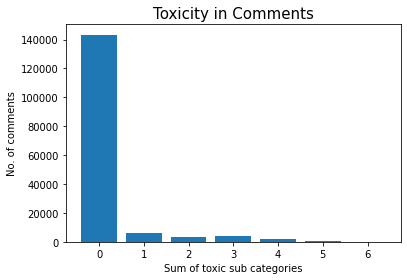

In [8]:
import matplotlib.pyplot as plt
plt.bar(x=df['toxicity'].value_counts().index,height=df['toxicity'].value_counts())
plt.xlabel("Sum of toxic sub categories")
plt.ylabel("No. of comments")
plt.title("Toxicity in Comments", fontsize=15)

#### Length of comments with no toxicity is 143346 so it's highly imbalanced.

#### Let's downsample this to the same as other toxic comments

In [9]:
#len of comments with no toxicity is 143346 so it's highly imbalanced.
#let's dowsample this to the sane as comments with some toxic elements
tox_len = len(df[df['toxicity']>0])

#undersample non-toxic comments
df_undersample = df[df['toxicity'] == 0].sample(n=tox_len, random_state=46)  # take non toxic comments
df_new = pd.concat([df[df['toxicity'] > 0], df_undersample])  # make new df
df_new.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3


# Data Cleaning

In [10]:
#remove id the toxicity score as that was only for the purpose of evaluating the data distribution
train_data = df_new.drop(['id','toxicity'],axis = 1)

In [13]:
test_data = pd.read_csv('gdrive/MyDrive/Colab Project - Jigsaw NLP/valid_combined.csv')

In [14]:
test_data.drop(['Unnamed: 0','id'],axis=1,inplace=True)

In [15]:
test_data

,comment_text
0,This article sucks \n\nwoo woo wooooooo
1,"""And yes, people should recognize that but the..."
2,"Western Media?\n\nYup, because every crime in..."
3,And you removed it! You numbskull! I don't car...
4,smelly vagina \n\nBluerasberry why don't you ...
...,...
60211,get out my large penis
60212,get out my large penis
60213,Piss off you slant eyed-gook
60214,Piss off you slant eyed-gook


### Text preprocessing

In [16]:
#function for text cleaning

from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

import re
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english'))
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/',' ',text)
        text = re.sub(r'\\',' ',text)
        text = re.sub(r'((http)\S+)','',text)
        text = re.sub('\s+', ' ', text)  # will remove more than one whitespace character
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        
        """ Replaces url address with "url" """
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
        text = re.sub(r'#([^\s]+)', r'\1', text)
        
        #remove multiple toxic words
        text = re.sub(r'(fuckfuck)','fuck fuck ',text)
        text = re.sub(r'(f+)( *)([u|*]+)( *)([c|*]+)( *)(k)+','fuck',text)
        text = re.sub(r'(s+ *h+ *i+ *t+)','shit',text)
        text = re.sub(r'([a|@][$|s][s|$])','ass',text)
        text = re.sub(r'(\bfuk\b)','fuck',text)
        text = re.sub(r'(\bpennnis\b)','penis',text)
        text = re.sub(r'(\bfggt\b)','faggot',text)
        text = re.sub(r'(\bfag\b)','faggot',text)
        
        #replaces abreviations
        text = re.sub(r"what's", "what is ",text)    
        text = re.sub(r"\'ve", " have ",text)
        text = re.sub(r"can't", "cannot ",text)
        text = re.sub(r"n't", " not ",text)
        text = re.sub(r"i'm", "i am ",text)
        text = re.sub(r"\'re", " are ",text)
        text = re.sub(r"\'d", " would ",text)
        text = re.sub(r"\'ll", " will ",text)
        text = re.sub(r"\'scuse", " excuse ",text)
        text = re.sub(r"\'s"," ",text)
        
        #remove unicode strings
        """ Removes unicode strings like "\u002c" and "x96" """
        text = re.sub(r'(\\u[0-9A-Fa-f]+)',r' ', text)       
        text = re.sub(r'[^\x00-\x7f]',r' ',text)
        
        """ Replaces "@user" with "atUser" """
        text = re.sub('@[^\s]+','atUser',text)
        
        text = [word for word in text.split() if word not in forbidden_words]
        
        
        
        #lemmatize words
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(word) for word in text]
        return text
    return []

In [18]:
import nltk

In [20]:
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [21]:
#text cleaning for train and test data
train_data['flag'] = 'TRAIN'
test_data['flag'] = 'TEST'
total_comments = pd.concat([train_data,test_data],axis = 0,ignore_index = True)
total_comments['comment_text'] = total_comments['comment_text'].apply(lambda x: ' '.join(text_cleaning(x)))

In [22]:
total_comments

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag
0,cocksucker piss around work,1.0,1.0,1.0,0.0,1.0,0.0,TRAIN
1,hey talk exclusive group wp taliban good destr...,1.0,0.0,0.0,0.0,0.0,0.0,TRAIN
2,bye look come think comming back tosser,1.0,0.0,0.0,0.0,0.0,0.0,TRAIN
3,gay antisemmitian archangel white tiger meow g...,1.0,0.0,1.0,0.0,1.0,1.0,TRAIN
4,fuck filthy mother as dry,1.0,0.0,1.0,0.0,1.0,0.0,TRAIN
...,...,...,...,...,...,...,...,...
92661,get large penis,NaN,NaN,NaN,NaN,NaN,NaN,TEST
92662,get large penis,NaN,NaN,NaN,NaN,NaN,NaN,TEST
92663,piss slant eyed gook,NaN,NaN,NaN,NaN,NaN,NaN,TEST
92664,piss slant eyed gook,NaN,NaN,NaN,NaN,NaN,NaN,TEST


## Building the model

In [23]:
max_features = 50000  # Only consider the top 50k words
maxlen = 200

In [24]:
all_comments = total_comments['comment_text'].tolist()
print(len(all_comments))
print(all_comments[200])

92666
aaron swartz stop fucking reverting goddamn edits think aaron swartz dumb as killed long time ago know live kill revert page


There are 92666 comments in our dataset

In [25]:
#One-hot encodes a text into a list of word indexes of size 50000
from keras.preprocessing.text import one_hot
vocab_size = 50000
encoded_comments = [one_hot(d, vocab_size) for d in all_comments]
encoded_comments[0]

[11316, 1081, 11220, 35864]

In [26]:
#save back to Phrase column
total_comments['comment_text'] = encoded_comments

In [27]:
total_comments.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag
0,"[11316, 1081, 11220, 35864]",1.0,1.0,1.0,0.0,1.0,0.0,TRAIN
1,"[3173, 23803, 11659, 39335, 25662, 13028, 4479...",1.0,0.0,0.0,0.0,0.0,0.0,TRAIN
2,"[34834, 17895, 37239, 32985, 1424, 48914, 40713]",1.0,0.0,0.0,0.0,0.0,0.0,TRAIN
3,"[38257, 4678, 35132, 19160, 26319, 33866, 2196...",1.0,0.0,1.0,0.0,1.0,1.0,TRAIN
4,"[45142, 42242, 37253, 32429, 12014]",1.0,0.0,1.0,0.0,1.0,0.0,TRAIN


In [28]:
#After preprocessing, seperate the train/test data
train_data = total_comments[total_comments['flag'] == 'TRAIN']
test_data = total_comments[total_comments['flag'] == 'TEST']

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

x_train = train_data['comment_text']
y_train = train_data[list_classes]

x_test = test_data['comment_text']
y_test = test_data[list_classes]

In [29]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(32450,)
(32450, 6)
(60216,)
(60216, 6)


In [30]:
#Pads sequences to the same length 200
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [31]:
x_train

array([[    0,     0,     0, ...,  1081, 11220, 35864],
       [    0,     0,     0, ...,  1994,  9671, 15929],
       [    0,     0,     0, ...,  1424, 48914, 40713],
       ...,
       [    0,     0,     0, ..., 47780, 38029, 28362],
       [    0,     0,     0, ..., 30442, 37340,  8440],
       [40639, 34398,  1573, ..., 11203, 16989, 12308]], dtype=int32)

In [32]:
#build LSTM model
model = Sequential()
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
model.add(inputs)
model.add(Embedding(50000, 128))
# Add 2 bidirectional LSTMs
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
# Add a classifier
model.add(Dense(6, activation="sigmoid"))
#model = keras.Model(inputs, outputs)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 6,598,406
Trainable params: 6,598,406
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
hist = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
812/812 [==============================] - 41s 40ms/step - loss: 0.2786 - accuracy: 0.9609 - val_loss: 0.0747 - val_accuracy: 0.9985
Epoch 2/5
812/812 [==============================] - 31s 38ms/step - loss: 0.2065 - accuracy: 0.9637 - val_loss: 0.0442 - val_accuracy: 0.9995
Epoch 3/5
812/812 [==============================] - 31s 38ms/step - loss: 0.1804 - accuracy: 0.9621 - val_loss: 0.0576 - val_accuracy: 0.9949
Epoch 4/5
812/812 [==============================] - 31s 38ms/step - loss: 0.1536 - accuracy: 0.9446 - val_loss: 0.0534 - val_accuracy: 0.9770
Epoch 5/5
812/812 [==============================] - 31s 38ms/step - loss: 0.1282 - accuracy: 0.8974 - val_loss: 0.0806 - val_accuracy: 0.7767


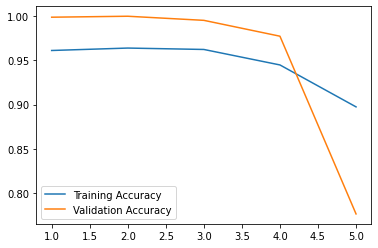

In [34]:
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

In [35]:
y_pred_lstm = model.predict(x_test)

## Save the model

In [ ]:
### Save model for later use:
from keras.models import load_model

model.save('LSTM_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

In [ ]:
del model  # deletes the existing model 

# returns a compiled model
# identical to the previous one
model = load_model('LSTM_model.h5')

### Preparing Submission file

In [ ]:
comments2score = pd.read_csv("jigsaw-toxic-severity-rating/comments_to_score.csv")

In [ ]:
#clean the comments to score file for kaggle submission
comments2score['text'] = comments2score['text'].apply(lambda x: ' '.join(text_cleaning(x)))

In [ ]:
comments2score

In [ ]:
comm2score = comments2score['text'].tolist()

In [ ]:
encoded_comm2score = [one_hot(d, vocab_size) for d in comm2score]

In [ ]:
#pad the comments
pre_comm2score = keras.preprocessing.sequence.pad_sequences(encoded_comm2score, maxlen=maxlen)

In [ ]:
y_pre_comm2score = model.predict(pre_comm2score)

In [ ]:
y_pre_comm2score

In [ ]:
y_pre_score = np.sum(y_pre_comm2score,axis=1)  

In [ ]:
y_pre_score

In [ ]:
comment_id = comments2score['comment_id'].tolist()

In [ ]:
df_sub = pd.DataFrame({"comment_id":comment_id, 'score':y_pre_score})

In [ ]:
df_sub

In [ ]:
df_sub.to_csv("submission3_lstm.csv", index=False)

## evaluating the model:



In [36]:
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag
32450,"[44297, 47438, 48899, 48899, 29884]",NaN,NaN,NaN,NaN,NaN,NaN,TEST
32451,"[41781, 49963, 36213, 44643, 4600, 7721, 36749...",NaN,NaN,NaN,NaN,NaN,NaN,TEST
32452,"[2881, 20097, 44016, 49816, 27163, 2876, 38802...",NaN,NaN,NaN,NaN,NaN,NaN,TEST
32453,"[19238, 15942, 38939, 30983, 8169, 26546, 4118...",NaN,NaN,NaN,NaN,NaN,NaN,TEST
32454,"[20646, 3147, 12458, 39164, 19398, 33633, 3147...",NaN,NaN,NaN,NaN,NaN,NaN,TEST


In [37]:
test_data[list_classes]=y_pred_lstm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [38]:
len(y_pred_lstm)

60216

In [39]:
test_data

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag
32450,"[44297, 47438, 48899, 48899, 29884]",0.978164,0.010925,0.951829,0.002005,0.121707,0.000745,TEST
32451,"[41781, 49963, 36213, 44643, 4600, 7721, 36749...",0.006698,0.000169,0.001070,0.001194,0.001418,0.000883,TEST
32452,"[2881, 20097, 44016, 49816, 27163, 2876, 38802...",0.972615,0.006879,0.079617,0.040420,0.528444,0.044149,TEST
32453,"[19238, 15942, 38939, 30983, 8169, 26546, 4118...",0.976346,0.001649,0.031402,0.037789,0.240729,0.006543,TEST
32454,"[20646, 3147, 12458, 39164, 19398, 33633, 3147...",0.908378,0.002725,0.150610,0.006214,0.236520,0.006367,TEST
...,...,...,...,...,...,...,...,...
92661,"[9734, 47556, 3147]",0.981252,0.022136,0.948198,0.005244,0.188517,0.000986,TEST
92662,"[9734, 47556, 3147]",0.981252,0.022136,0.948198,0.005244,0.188517,0.000986,TEST
92663,"[1081, 23859, 18264, 40443]",0.992126,0.062678,0.982774,0.010873,0.297195,0.002447,TEST
92664,"[1081, 23859, 18264, 40443]",0.992126,0.062678,0.982774,0.010873,0.297195,0.002447,TEST


In [40]:
cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
#get the toxicity score based on the sum of all sub categories
test_data['score'] = test_data[cols].sum(axis=1);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
scores = test_data['score'].tolist()

In [42]:
len(scores)

60216

In [43]:
less_toxic_score=[]
more_toxic_score=[]
#the first 30108 rows are less_toxic
for i in range(30108):
    less_toxic_score.append(scores[i])
for i in range(30108,len(scores)):
    more_toxic_score.append(scores[i])

In [44]:
#comparing the results of the validation set:
result=[]
for i in range(len(less_toxic_score)):
    if less_toxic_score[i]<more_toxic_score[i]:
        result.append(1)
    else:
        result.append(0)

In [46]:
#adding the validation dataset
validation_data = pd.read_csv('gdrive/MyDrive/Colab Project - Jigsaw NLP/4th_dataset/validation_data.csv')

In [47]:
validation_data

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"
...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook


In [48]:
validation_data['less_toxic_score']=less_toxic_score
validation_data['more_toxic_score']=more_toxic_score
validation_data['result']=result

In [49]:
validation_data

,worker,less_toxic,more_toxic,less_toxic_score,more_toxic_score,result
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,2.065375,0.900683,0
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,0.011432,1.088748,1
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",1.672125,0.012403,0
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,1.294458,3.240608,1
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",1.310814,2.040342,1
...,...,...,...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,1.432791,2.146333,1
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,1.432791,2.146333,1
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,0.870293,2.348092,1
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,0.870293,2.348092,1


In [50]:
validation_data['result'].value_counts(normalize=True)

1    0.681447
0    0.318553
Name: result, dtype: float64

In [51]:
#Accuracy on validation set with 5 epochs and 0.2 split

# 1    0.686362
# 0    0.313638
# Name: result, dtype: float64

#Accuracy on validation set with 2 epochs and 0.2 split
# 1    0.684403
# 0    0.315597
# Name: result, dtype: float64

### We are only able to achieve 68.5% accuracy on validation dataset

#### Let's see if the accuracy is different on validation score if we give adjusted weights to the sub-categories rather than simply taking the sum

In [52]:
#make a copy of the test data
test_data2 = test_data.copy()

In [53]:
test_data2

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag,score
32450,"[44297, 47438, 48899, 48899, 29884]",0.978164,0.010925,0.951829,0.002005,0.121707,0.000745,TEST,2.065375
32451,"[41781, 49963, 36213, 44643, 4600, 7721, 36749...",0.006698,0.000169,0.001070,0.001194,0.001418,0.000883,TEST,0.011432
32452,"[2881, 20097, 44016, 49816, 27163, 2876, 38802...",0.972615,0.006879,0.079617,0.040420,0.528444,0.044149,TEST,1.672125
32453,"[19238, 15942, 38939, 30983, 8169, 26546, 4118...",0.976346,0.001649,0.031402,0.037789,0.240729,0.006543,TEST,1.294458
32454,"[20646, 3147, 12458, 39164, 19398, 33633, 3147...",0.908378,0.002725,0.150610,0.006214,0.236520,0.006367,TEST,1.310814
...,...,...,...,...,...,...,...,...,...
92661,"[9734, 47556, 3147]",0.981252,0.022136,0.948198,0.005244,0.188517,0.000986,TEST,2.146333
92662,"[9734, 47556, 3147]",0.981252,0.022136,0.948198,0.005244,0.188517,0.000986,TEST,2.146333
92663,"[1081, 23859, 18264, 40443]",0.992126,0.062678,0.982774,0.010873,0.297195,0.002447,TEST,2.348092
92664,"[1081, 23859, 18264, 40443]",0.992126,0.062678,0.982774,0.010873,0.297195,0.002447,TEST,2.348092


In [54]:
#let's create category weights for each of the labels in Kaggle's 1st training datset

# Create a score that messures how much toxic is a comment
cat_weights = {'obscene': 0.32, 'toxic': 1, 'threat': 1.5, 
            'insult': 0.64, 'severe_toxic': 1.5, 'identity_hate': 1.5}

for category in cat_weights:
    test_data2[category] = test_data2[category] * cat_weights[category]

In [55]:
test_data2['score'] = test_data2[cols].sum(axis=1);

In [56]:
test_data2

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag,score
32450,"[44297, 47438, 48899, 48899, 29884]",0.978164,0.016388,0.304585,0.003008,0.077892,0.001118,TEST,1.381155
32451,"[41781, 49963, 36213, 44643, 4600, 7721, 36749...",0.006698,0.000253,0.000343,0.001790,0.000907,0.001325,TEST,0.011316
32452,"[2881, 20097, 44016, 49816, 27163, 2876, 38802...",0.972615,0.010319,0.025477,0.060631,0.338204,0.066224,TEST,1.473470
32453,"[19238, 15942, 38939, 30983, 8169, 26546, 4118...",0.976346,0.002474,0.010049,0.056683,0.154067,0.009815,TEST,1.209433
32454,"[20646, 3147, 12458, 39164, 19398, 33633, 3147...",0.908378,0.004088,0.048195,0.009321,0.151373,0.009551,TEST,1.130905
...,...,...,...,...,...,...,...,...,...
92661,"[9734, 47556, 3147]",0.981252,0.033203,0.303423,0.007866,0.120651,0.001478,TEST,1.447874
92662,"[9734, 47556, 3147]",0.981252,0.033203,0.303423,0.007866,0.120651,0.001478,TEST,1.447874
92663,"[1081, 23859, 18264, 40443]",0.992126,0.094018,0.314488,0.016309,0.190205,0.003670,TEST,1.610815
92664,"[1081, 23859, 18264, 40443]",0.992126,0.094018,0.314488,0.016309,0.190205,0.003670,TEST,1.610815


In [65]:
#Adding the scores for less toxic and more toxic in validation set
scores2 = test_data2['score'].tolist()

less_toxic_score2=[]
more_toxic_score2=[]
#the first 30108 rows are less_toxic
for i in range(30108):
    less_toxic_score2.append(scores2[i])
for i in range(30108,len(scores)):
    more_toxic_score2.append(scores2[i])
    
#comparing the results of the validation set:
result2=[]
for i in range(len(less_toxic_score2)):
    if less_toxic_score2[i]<more_toxic_score2[i]:
        result2.append(1)
    else:
        result2.append(0)

#adding the validation dataset
validation_data2 = pd.read_csv('gdrive/MyDrive/Colab Project - Jigsaw NLP/4th_dataset/validation_data.csv')

#
validation_data2['less_toxic_score']=less_toxic_score2
validation_data2['more_toxic_score']=more_toxic_score2
validation_data2['result']=result2

In [66]:
validation_data2

,worker,less_toxic,more_toxic,less_toxic_score,more_toxic_score,result
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,1.381155,0.874672,0
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,0.011316,1.067891,1
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",1.473470,0.012539,0
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,1.209433,2.373268,1
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",1.130905,2.132458,1
...,...,...,...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,0.885872,1.447874,1
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,0.885872,1.447874,1
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,0.858409,1.610815,1
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,0.858409,1.610815,1


In [67]:
validation_data2['result'].value_counts(normalize=True)

1    0.677627
0    0.322373
Name: result, dtype: float64

#### Accuracy is not much improved using the scoring multiplication strategy. It's only 68.5%

### Let's try binarizing the porbabilities in the test data and see if it makes any difference

In [58]:
#make a copy of the test data
test_data3 = test_data.copy()

In [59]:
test_data3

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag,score
32450,"[44297, 47438, 48899, 48899, 29884]",0.978164,0.010925,0.951829,0.002005,0.121707,0.000745,TEST,2.065375
32451,"[41781, 49963, 36213, 44643, 4600, 7721, 36749...",0.006698,0.000169,0.001070,0.001194,0.001418,0.000883,TEST,0.011432
32452,"[2881, 20097, 44016, 49816, 27163, 2876, 38802...",0.972615,0.006879,0.079617,0.040420,0.528444,0.044149,TEST,1.672125
32453,"[19238, 15942, 38939, 30983, 8169, 26546, 4118...",0.976346,0.001649,0.031402,0.037789,0.240729,0.006543,TEST,1.294458
32454,"[20646, 3147, 12458, 39164, 19398, 33633, 3147...",0.908378,0.002725,0.150610,0.006214,0.236520,0.006367,TEST,1.310814
...,...,...,...,...,...,...,...,...,...
92661,"[9734, 47556, 3147]",0.981252,0.022136,0.948198,0.005244,0.188517,0.000986,TEST,2.146333
92662,"[9734, 47556, 3147]",0.981252,0.022136,0.948198,0.005244,0.188517,0.000986,TEST,2.146333
92663,"[1081, 23859, 18264, 40443]",0.992126,0.062678,0.982774,0.010873,0.297195,0.002447,TEST,2.348092
92664,"[1081, 23859, 18264, 40443]",0.992126,0.062678,0.982774,0.010873,0.297195,0.002447,TEST,2.348092


In [60]:
cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for col in cols:
    test_data3[col] = test_data3[col].apply(lambda x: 1 if x >= 0.5 else 0)

In [61]:
test_data3

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag,score
32450,"[44297, 47438, 48899, 48899, 29884]",1,0,1,0,0,0,TEST,2.065375
32451,"[41781, 49963, 36213, 44643, 4600, 7721, 36749...",0,0,0,0,0,0,TEST,0.011432
32452,"[2881, 20097, 44016, 49816, 27163, 2876, 38802...",1,0,0,0,1,0,TEST,1.672125
32453,"[19238, 15942, 38939, 30983, 8169, 26546, 4118...",1,0,0,0,0,0,TEST,1.294458
32454,"[20646, 3147, 12458, 39164, 19398, 33633, 3147...",1,0,0,0,0,0,TEST,1.310814
...,...,...,...,...,...,...,...,...,...
92661,"[9734, 47556, 3147]",1,0,1,0,0,0,TEST,2.146333
92662,"[9734, 47556, 3147]",1,0,1,0,0,0,TEST,2.146333
92663,"[1081, 23859, 18264, 40443]",1,0,1,0,0,0,TEST,2.348092
92664,"[1081, 23859, 18264, 40443]",1,0,1,0,0,0,TEST,2.348092


In [62]:
#sum the scores of binary categories
test_data3['score_bin'] = test_data3[cols].sum(axis=1);

In [63]:
test_data3

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag,score,score_bin
32450,"[44297, 47438, 48899, 48899, 29884]",1,0,1,0,0,0,TEST,2.065375,2
32451,"[41781, 49963, 36213, 44643, 4600, 7721, 36749...",0,0,0,0,0,0,TEST,0.011432,0
32452,"[2881, 20097, 44016, 49816, 27163, 2876, 38802...",1,0,0,0,1,0,TEST,1.672125,2
32453,"[19238, 15942, 38939, 30983, 8169, 26546, 4118...",1,0,0,0,0,0,TEST,1.294458,1
32454,"[20646, 3147, 12458, 39164, 19398, 33633, 3147...",1,0,0,0,0,0,TEST,1.310814,1
...,...,...,...,...,...,...,...,...,...,...
92661,"[9734, 47556, 3147]",1,0,1,0,0,0,TEST,2.146333,2
92662,"[9734, 47556, 3147]",1,0,1,0,0,0,TEST,2.146333,2
92663,"[1081, 23859, 18264, 40443]",1,0,1,0,0,0,TEST,2.348092,2
92664,"[1081, 23859, 18264, 40443]",1,0,1,0,0,0,TEST,2.348092,2


In [68]:
#Adding the scores for less toxic and more toxic in validation set
scores3 = test_data3['score_bin'].tolist()

less_toxic_score3=[]
more_toxic_score3=[]
#the first 30108 rows are less_toxic
for i in range(30108):
    less_toxic_score3.append(scores3[i])
for i in range(30108,len(scores)):
    more_toxic_score3.append(scores3[i])
    
#comparing the results of the validation set:
result3=[]
for i in range(len(less_toxic_score3)):
    if less_toxic_score3[i]<more_toxic_score3[i]:
        result3.append(1)
    else:
        result3.append(0)

#adding the validation dataset
validation_data3 = pd.read_csv('gdrive/MyDrive/Colab Project - Jigsaw NLP/4th_dataset/validation_data.csv')

#
validation_data3['less_toxic_score']=less_toxic_score3
validation_data3['more_toxic_score']=more_toxic_score3
validation_data3['result']=result3

In [69]:
validation_data3

,worker,less_toxic,more_toxic,less_toxic_score,more_toxic_score,result
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,2,1,0
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,0,1,1
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",2,0,0
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,1,3,1
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",1,1,0
...,...,...,...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,2,2,0
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,2,2,0
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,1,2,1
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,1,2,1


In [70]:
validation_data3['result'].value_counts(normalize=True)

1    0.538594
0    0.461406
Name: result, dtype: float64

#### Accuracy is reduced using the binary sum of categories

#### let's try taking weighted sum of binary scores

In [71]:
# Create a score that messures how much toxic is a comment
cat_weights = {'obscene': 0.32, 'toxic': 0.64, 'threat': 1.5, 
            'insult': 0.64, 'severe_toxic': 1.5, 'identity_hate': 1.5}

for category in cat_weights:
    test_data3[category] = test_data2[category] * cat_weights[category]

#sum the scores of binary categories
test_data3['score_weighted'] = test_data3[cols].sum(axis=1);

In [72]:
test_data3

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,flag,score,score_bin,score_weighted
32450,"[44297, 47438, 48899, 48899, 29884]",0.626025,0.024582,0.097467,0.004512,0.049851,0.001676,TEST,2.065375,2,0.804114
32451,"[41781, 49963, 36213, 44643, 4600, 7721, 36749...",0.004287,0.000379,0.000110,0.002686,0.000581,0.001988,TEST,0.011432,0,0.010029
32452,"[2881, 20097, 44016, 49816, 27163, 2876, 38802...",0.622473,0.015479,0.008153,0.090946,0.216451,0.099336,TEST,1.672125,2,1.052838
32453,"[19238, 15942, 38939, 30983, 8169, 26546, 4118...",0.624861,0.003711,0.003216,0.085025,0.098603,0.014722,TEST,1.294458,1,0.830138
32454,"[20646, 3147, 12458, 39164, 19398, 33633, 3147...",0.581362,0.006132,0.015422,0.013982,0.096879,0.014326,TEST,1.310814,1,0.728102
...,...,...,...,...,...,...,...,...,...,...,...
92661,"[9734, 47556, 3147]",0.628001,0.049805,0.097095,0.011799,0.077217,0.002218,TEST,2.146333,2,0.866135
92662,"[9734, 47556, 3147]",0.628001,0.049805,0.097095,0.011799,0.077217,0.002218,TEST,2.146333,2,0.866135
92663,"[1081, 23859, 18264, 40443]",0.634960,0.141026,0.100636,0.024463,0.121731,0.005505,TEST,2.348092,2,1.028323
92664,"[1081, 23859, 18264, 40443]",0.634960,0.141026,0.100636,0.024463,0.121731,0.005505,TEST,2.348092,2,1.028323


In [74]:
#Adding the scores for less toxic and more toxic in validation set
scores4 = test_data3['score_weighted'].tolist()

less_toxic_score4=[]
more_toxic_score4=[]
#the first 30108 rows are less_toxic
for i in range(30108):
    less_toxic_score4.append(scores4[i])
for i in range(30108,len(scores)):
    more_toxic_score4.append(scores4[i])
    
#comparing the results of the validation set:
result4=[]
for i in range(len(less_toxic_score4)):
    if less_toxic_score4[i]<more_toxic_score4[i]:
        result4.append(1)
    else:
        result4.append(0)

#adding the validation dataset
validation_data4 = pd.read_csv('gdrive/MyDrive/Colab Project - Jigsaw NLP/4th_dataset/validation_data.csv')

#
validation_data4['less_toxic_score']=less_toxic_score4
validation_data4['more_toxic_score']=more_toxic_score4
validation_data4['result']=result4

In [75]:
validation_data4

,worker,less_toxic,more_toxic,less_toxic_score,more_toxic_score,result
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,0.804114,0.574140,0
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,0.010029,0.724763,1
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",1.052838,0.011073,0
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,0.830138,1.804948,1
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",0.728102,2.104276,1
...,...,...,...,...,...,...
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,0.491475,0.866135,1
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,0.491475,0.866135,1
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,0.564049,1.028323,1
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,0.564049,1.028323,1


In [76]:
validation_data4['result'].value_counts(normalize=True)

1    0.674007
0    0.325993
Name: result, dtype: float64

#### weighted sum offers better accuracy on validation data with accuracy of 0.684502